# Setup and data cleaning

In [536]:
# Dependencies
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

In [491]:
# Import movies (IMDB)
title_basics = pd.read_csv('../data/title.basics.tsv',delimiter='\t',encoding='utf-8-sig', low_memory=False)

# Import ratings
title_ratings = pd.read_csv('../data/title.ratings.tsv',delimiter='\t',encoding='utf-8-sig')

# Import crew
title_crew = pd.read_csv('../data/title.crew.tsv',delimiter='\t',encoding='utf-8-sig')

# Import name basics
name_basics = pd.read_csv('../data/name.basics.tsv',delimiter='\t',encoding='utf-8-sig')

# Import box office data (BoxOfficeMojo)
box_office = pd.read_csv('../data/boxoffice.csv')

# Import Oscar data (https://en.wikipedia.org/wiki/List_of_Academy_Award-winning_films)
oscars = pd.read_csv('../data/oscars_cleaned.csv')

In [492]:
# Filter non-movies, adult movies
title_filtered = title_basics[title_basics['titleType']=='movie']
title_filtered = title_filtered[title_filtered['isAdult']==0]

In [493]:
# Split out genres and join
genres_split = title_filtered["genres"].str.split(",", n=2, expand=True)
joined = title_filtered.join(genres_split)

# Rename and drop some columns
cleaned = joined.rename(columns = {'tconst':'IMDB ID', 'titleType': 'Type', 'primaryTitle': 'Title', 'originalTitle': 'Title (original)', 'startYear': 'Year', 'runtimeMinutes': 'Runtime (min)', 0:'Genre (main)', 1:'Genre (sub 1)', 2:'Genre (sub 2)'})
cleaned = cleaned.drop(columns=['endYear', 'genres', 'Genre (sub 1)', 'Genre (sub 2)', 'Title (original)'])

In [494]:
# Merge basic set and rating
with_ratings = cleaned.set_index('IMDB ID').join(title_ratings.set_index('tconst'))
with_ratings = with_ratings.rename(columns = {'averageRating': 'Rating (avg.)', 'numVotes': 'Votes'})

# Merge box office and Oscars
merged = pd.merge(box_office, oscars, left_on='title', right_on='Film', how='outer')

# Merge both of above to make combined set
combined = with_ratings.merge(merged,how='left', left_on='Title', right_on='title')

In [495]:
# Drop, rename, change \N to NaN
combined = combined.drop(['Type', 'isAdult', 'Year_y', 'year', 'rank', 'title', 'Film'], axis=1)
combined = combined.rename(columns = {'Year_x': 'Year', 'studio': 'Studio', 'lifetime_gross': 'Gross (lifetime)'})
combined = combined.replace(r'\\N','NaN', regex=True)

In [496]:
## FIX RUNTIME NaN #dropped = combined[combined['Runtime (min)']!='NaN']
## DROP TO MAKE PROTOTYPING EASIER
dropped = combined.dropna(axis='rows')
dropped.head()

,Title,Year,Runtime (min),Genre (main),Rating (avg.),Votes,Studio,Gross (lifetime),Awards,Nominations
415,Anna Karenina,1914,NaN,Drama,5.6,14.0,Focus,12816367.0,1.0,4.0
902,Anna Karenina,1915,NaN,Drama,4.3,7.0,Focus,12816367.0,1.0,4.0
2124,The Patriot,1916,50,Western,7.4,8.0,Sony,113330342.0,1.0,5.0
2701,Great Expectations,1917,50,Drama,5.8,16.0,Fox,26420672.0,2.0,5.0
3306,Anna Karenina,1918,53,Drama,5.3,18.0,Focus,12816367.0,1.0,4.0


# Machine Learning: Regression

In [497]:
# Reset index to avoid sklearn problems
dropped = dropped.reset_index()
dropped = dropped.drop(['index'], axis=1)

In [499]:
dropped.head()

,Title,Year,Runtime (min),Genre (main),Rating (avg.),Votes,Studio,Gross (lifetime),Awards,Nominations
0,Anna Karenina,1914,NaN,Drama,5.6,14.0,Focus,12816367.0,1.0,4.0
1,Anna Karenina,1915,NaN,Drama,4.3,7.0,Focus,12816367.0,1.0,4.0
2,The Patriot,1916,50,Western,7.4,8.0,Sony,113330342.0,1.0,5.0
3,Great Expectations,1917,50,Drama,5.8,16.0,Fox,26420672.0,2.0,5.0
4,Anna Karenina,1918,53,Drama,5.3,18.0,Focus,12816367.0,1.0,4.0


In [520]:
## FIX NaN
## DUPLICATES
## More data: Budget, Country (e.g. most popular genres by country)

# X and x
# TODO: VOTES AGAINST GROSS, RATING AGAINST AWARDS, RATING AGAINST GROSS, GENRES

# Calculate avg gross ($) per movie
#box_plot['Avg. lifetime gross'] = box_plot['lifetime_gross']/box_plot['title']

# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = dropped['Rating (avg.)'].values.reshape(-1, 1)
y = dropped['Votes'].values.reshape(-1, 1)
print("Shape: ", X.shape, y.shape)

Shape:  (979, 1) (979, 1)


Text(0, 0.5, 'Votes')

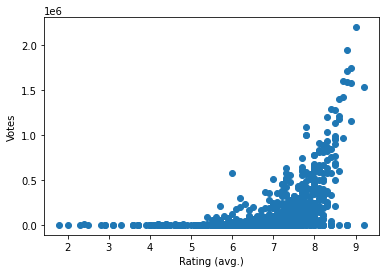

In [501]:
# Plot the data to see if a linear trend exists
plt.scatter(X, y)
plt.xlabel('Rating (avg.)')
plt.ylabel('Votes')

In [502]:
# Use sklearn's `train_test_split` to split the data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [503]:
# Drop NaN
X = X[np.logical_not(np.isnan(X))]
y = y[np.logical_not(np.isnan(y))]

In [504]:
# Fit model to training data. Ccalculate scores for training and testing data
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [505]:
# Calculate mean_squared_error and r-squared value for testing data
from sklearn.metrics import mean_squared_error, r2_score

# Use model to make predictions
predicted = model.predict(x_test)

# Score predictions with Mean Squared Error and R-squared
mse = mean_squared_error(y_test, predicted)
r2 = r2_score(y_test, predicted)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")

Mean Squared Error (MSE): 53475315600.29304
R-squared (R2): 0.22036745284286663


In [506]:
# Call the `score` method on the model to show the r2 score
model.score(X_test, y_test)

0.22036745284286663

In [507]:
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

print(f"Training score: {training_score}")
print(f"Testing score: {testing_score}")

Training score: 0.219272097900587
Testing score: 0.22036745284286663


Text(0.5, 1.0, 'Residual plot')

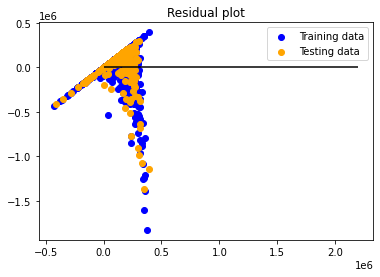

In [508]:
## LABEL
# Plot the Residuals for the Training and Testing data
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual plot")

# Machine Learning: Multiple Linear Regression [WIP]

In [541]:
# Assign data to X, y (Sklearn requires a two-dimensional array of values so we use reshape to create this)
X = dropped['Rating (avg.)'].values.reshape(-1, 1)
y = dropped['Votes'].values.reshape(-1, 1)
print("Shape: ", X.shape, y.shape)

Shape:  (979, 1) (979, 1)


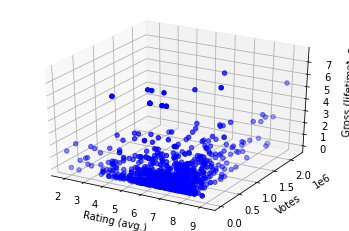

In [548]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = dropped['Rating (avg.)']
y = dropped['Votes']
z = dropped['Gross (lifetime)']

ax.scatter(x, y, z, c='b')
ax.set_xlabel('Rating (avg.)')
ax.set_ylabel('Votes')
ax.set_zlabel('Gross (lifetime)')


plt.show()

In [550]:
## TUTORIAL 
# Note: The weights are how important each feature is to the equation. This is the part that the algorithm has to learn. Multiple Linear Regression simply means that you have more than one feature variable.
# Generate a linear dataset with three features

from sklearn.datasets import make_regression

n_features = 3
X, y = make_regression(n_samples=30, n_features=n_features, n_informative=n_features, random_state=42,  noise=0.5, bias=100.0)
print(X.shape)

(30, 3)


In [551]:
# We can still visualize 3 features as a 3D plot, but what about n-dimensions? This becomes very difficult for the human brain to visualize.
# We could pick just one feature from X to fit our model, but what we really want it to find a line that best fits the data in n-dimensional space. To achieve this, Linear Regression can be solved using the analytical approach called Ordinary Least Squares or a computational approach Gradient Descent for estimating the parameters. Note that there are tradeoffs between using either approach. The Linear Regression model in Sklearn uses the Ordinary Least Squares method.
# Luckily, we can just supply our n-dimensional features and sklearn will fit the model using all of our features.

from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Fitting our model with all of our features in X
model.fit(X, y)
score = model.score(X, y)
print(f"R2 Score: {score}")

R2 Score: 0.9999838079561165


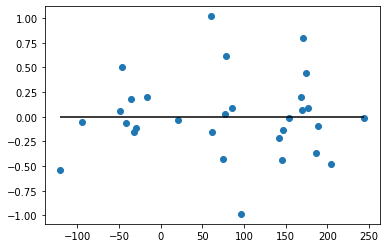

In [545]:
# Because we can't easily plot our line in 3D space, we can use a residual plot to check our predictions. Residuals are the difference between the true values of y and the predicted values of y.
# We want our predictions to be close to zero on the y-axis in this plot.

predictions = model.predict(X)

# Plot residuals
plt.scatter(predictions, predictions - y)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.show()